In [1]:
import numpy as np
import xarray as xr
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm
from scipy.optimize import fsolve

## The model

Consider the following modification to the heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q(t)}{\rho_0 c_p z_m} - \gamma\big(T - (T_i(z) + T_0(t))\big) \bigg) \times H(z_m - z) - \mu \big(T - T_i(z) \big) \times H(z - z_d) + \text{C.A.},$$ 

where $T = T(t, z)$ is the temperature (MAKE A NOTE OF WHETHER WE THINK OF THIS AS POTENTIAL, CONSERVATIVE, IN SITU, ETC.); $\kappa$ is the (constant) diffusivity; $Q(t)$ is a prescribed, time-dependent surface heat flux; $\rho_0 = 1025$ kg m$^{-3}$ is the reference density; $c_p = 4000$ J/(kg C) is the specific heat capacity; $z_m$ is the depth of the mix*ing* layer (i.e., a minimum mixed layer); $\gamma$ is a damping term (acting like a climate feedback parameter) which acts to restore the surface back to some initial state $T_i(z)$. The term $T_0$ is applied in perturbations to perturb the surface temperature (like an air temperature perturbation). The $H$ represents a Heaviside function to denote that this forcing and restoring is applied over the minimum mixing layer. The next term is a deep ocean restoring term which acts to balance the surface restoring at the surface. This is so that the steady-state solution is not simply a profile of constant temperature equal to the surface temperature. The paramater $\mu$ is a characteristic timescale over which the temperature profile is relaxed back to its initial profile $T_i(z)$ in the deep ocean (e.g., 20 years), applied only below some prescribed depth $z_d$ (e.g., $z_d = 900$m).

Finally, the term 'C.A.' denotes a convective adjustment algorithm, following _Rahmstorf (1993)_, which checks at each timestep whether any convective instabilities arise and removes them conservatively.

_Make a note of the initial and boundary conditions._

We will write a forward-time, central-space finite difference scheme for this initial-boundary value problem. I have also solved analytically for the steady-state solution, which can be found in an Appendeix to the thesis.

In [2]:
# Constants, data, parameters...

rho = 1035 # kg/m^3
c = 4000 # J/(kg C)

z_m = 25.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

lambd = 8/(1.2 - 1.0)
gamma = lambd / (rho * c * z_m)
kappa = 5e-06
mu = 1/(5 * 365 * 86400)

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell


# Initial condition: constant in mixing layer, linearly stratified elsewhere

def initial_condition(z_t):
    mixing_index = (np.abs(z_t - z_m)).argmin() # Index in z_t exactly dz/2 m above z_m.
    mixing_layer = T_0 * np.ones(mixing_index + 1)
    z_t = z_t[mixing_index + 1:]
    thermocline = ((T_0 - T_b) * z_t - (T_0 * z_b - T_b * z_m)) / (z_m - z_b)
    return np.concatenate((mixing_layer, thermocline), axis = None)

T_i = initial_condition(z_t)

# Analytical steady state, cf. Appendix B

def steady_state(Z):
    
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # Coefficients
    a_1 = (A * E + B * F) / (A * D - C * F)
    
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # Piecewise defined function (ie, need to use vectorise):
    if Z <= z_m:
        
        return T_0 + a_1 * (np.exp(Z * np.sqrt(gamma / kappa)) + np.exp( - Z * np.sqrt(gamma / kappa)))
    
    elif Z > z_m and Z < z_d:
        
        return T_0 + a_1 * (np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (Z - z_m) \
                            + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    else:
        
        return ((T_0 - T_b) * Z + z_m * T_b - z_b * T_0) / (z_m - z_b) \
    + c_1 * (1 + np.exp(2 * (z_b - Z) * np.sqrt(mu / kappa))) * np.exp(Z * np.sqrt(mu / kappa)) \
    + np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b) * np.exp((z_b - Z) * np.sqrt(mu / kappa))
    
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)


### Intermediate functions

def convective_adjustment(T, z_m):
        
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_m / dz) + 1):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)



### Ocean heat content

def OHC(T):
    
    OHC = np.empty(T.shape[1])
    
    for i in range(len(OHC)):
        
        ACCESS_ave_depth = 3642
        
        #OHC[i] = rho * c * np.cumsum(T[: , i])[- 1] * dz # This is for ocean heat content
        
        OHC[i] = z_b / ACCESS_ave_depth * np.mean(T[:, i]) # This is for average temperature
        
    return OHC 




### The forward-in-time, central-in-space scheme with restoring and flux boundary conditions ###

def model(dt, dz, z_m, z_d, z_b, kappa, lambd, T_initial, Q, T0, years):
    
    # Data
    days = dt / 86400 # Timestep in days
    M = int(z_b / dz) # Number of spatial steps evaluated at the top/bottom of the grid cell
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, z_b, M + 1) # Depth at top/bottom of grid cell
    z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell 
    t = np.linspace(0.0, years * 360, N + 1)
    Hdeep = np.heaviside(z - z_d, 1) # 1 below z = z_d, 0 elsewhere
    Hmix = np.heaviside(z_m - z, 0) # 1 above z = z_m, 0 elsewhere
    radiative_forcing = Q / (c * rho * z_m)
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    T = np.zeros((M, N + 1)) # i.e. evaluated at the middle of grid cell
    F = np.zeros((M + 1, N + 1)) # i.e. evaluated at the top/bottom of grid cell
    
    T[:, 0] = T_initial # Initial condition
    F[0, :] = 0 # No flux at surface
    F[- 1, :] = 0 # No flux at base
        
    for n in range(0, N):
    
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
             
            #NB: T_i = T_i(z), the initial profile
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) \
            + dt * (radiative_forcing[n] - gamma * (T[m, n] - (T0[n] + T_i[m]))) * Hmix[m]  \
            - dt * mu * (T[m, n] - T_i[m]) * Hdeep[m]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1], z_m)
        
    return T


# Solving numerically for mu

def eqn(mu, kappa):
    # Paramaters
    A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
    
    B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
    
    C = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa))) * (z_d - z_m) \
    + np.exp(z_m * np.sqrt(gamma / kappa)) + np.exp( - z_m * np.sqrt(gamma / kappa))
    
    D = np.sqrt(gamma / kappa) * (np.exp(z_m * np.sqrt(gamma / kappa)) - np.exp( - z_m * np.sqrt(gamma / kappa)))
    
    E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
    
    F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
    
    # C_1
    c_1 = (C * E + B * D) / (A * D - C * F)
    
    # The equation
    T_b_final = T_b + 0.5
    
    equation = T_b_final - T_b - 2 * np.exp(np.sqrt(mu / kappa) * z_b) * c_1 - np.sqrt(kappa / mu) * (T_0 - T_b) / (z_m - z_b)
    
    return equation 

In [3]:
# Set length of experiment

years = 170
days = dt / 86400
M = int(z_b / dz)
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

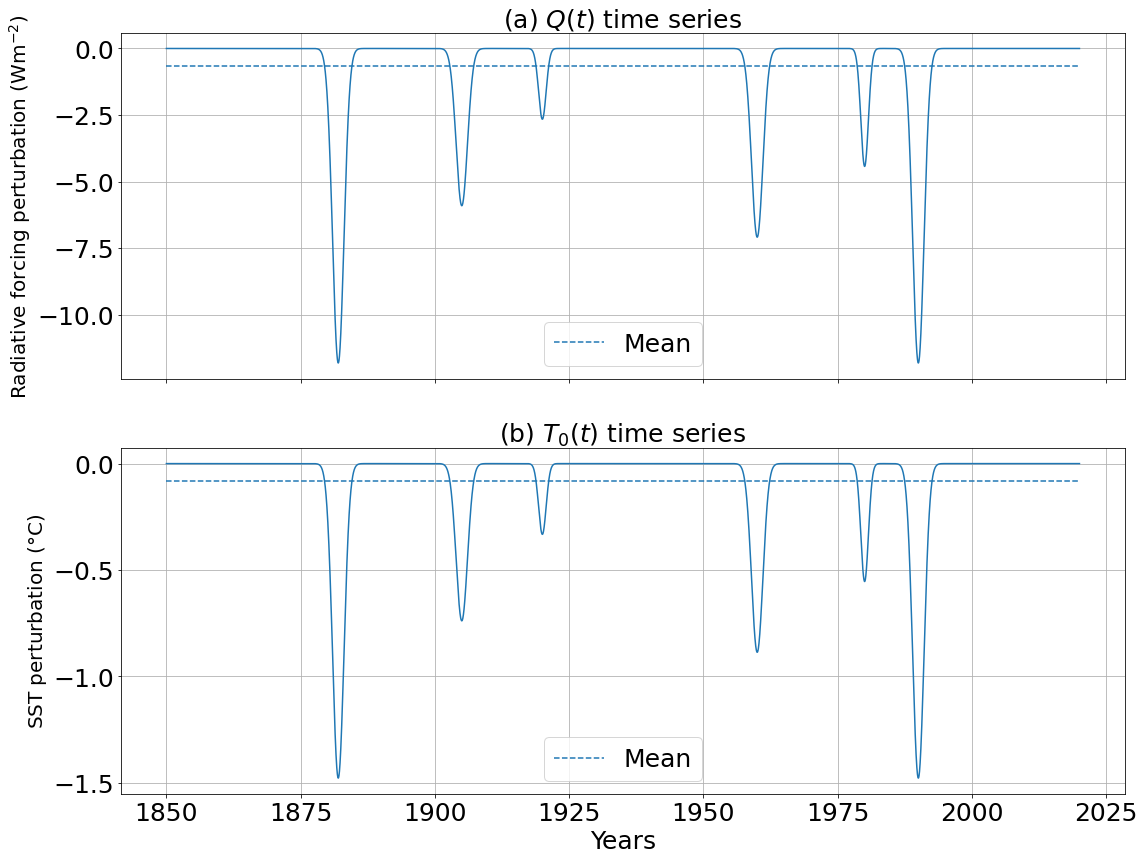

In [4]:
def normal(t, mu_year, sigma_year):
    mu = mu_year * 360
    sigma = sigma_year * 360
    return 1 / (np.sqrt(2 * np.pi * sigma**2)) * np.exp(- ((t - mu)/(sigma)) ** 2)

T0_volc_var = (-2000*normal(t, 32, 1.5) \
                          - 1000*normal(t, 55, 1.5) \
                         - 300*normal(t, 70, 1.) \
                         - 1200*normal(t, 110, 1.5) \
                         - 500*normal(t, 130, 1.0) \
                         - 2000*normal(t, 140, 1.5))

Q_volc_var = 8 * T0_volc_var

fig, axs = plt.subplots(ncols=1, nrows=2, figsize = (18, 14), sharex=True)

ax = axs[0]
ax.plot(1850 + t/360, Q_volc_var)
ax.axhline(y=np.mean(Q_volc_var), xmin=0.045, xmax=1-0.045, linestyle='--', label='Mean')
ax.set_title('(a) $Q(t)$ time series', fontsize=25)
ax.set_xlabel('', fontsize=25)
ax.set_ylabel('Radiative forcing perturbation (Wm$^{-2}$)', fontsize=20)
ax.tick_params(labelsize=25)
ax.grid()
ax.legend(fontsize=25, loc='lower center')

ax=axs[1]
ax.plot(1850 + t/360, T0_volc_var)
ax.axhline(y=np.mean(T0_volc_var), xmin=0.045, xmax=1-0.045, linestyle='--', label='Mean')
ax.set_title('(b) $T_0(t)$ time series', fontsize=25)
ax.set_xlabel('Years', fontsize=25)
ax.set_ylabel('SST perturbation ($\degree$C)', fontsize=20)
ax.tick_params(labelsize=25)
ax.grid()
ax.legend(fontsize=25, loc='lower center')

# plt.savefig('ch5_idealised_volcanoes.jpg')

In [5]:
# cont (no forcing)

kappa = 5e-6
v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)

T0_cont = np.full_like(t, 0)
Q_cont = np.full_like(t, 0)

T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years)



# volc_var (variable volcanic forcing)

T_volc_var = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_var, T0_volc_var, years)



# volc_cst (constant volcanic forcing equal to time-mean of variable volcanic forcing)

T0_volc_cst = np.mean(T0_volc_var) * np.full_like(t, 1)
Q_volc_cst = np.mean(Q_volc_var) * np.full_like(t, 1)

T_volc_cst = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_cst, T0_volc_cst, years)



# volc_anom (variable volcanic forcing but offset by the mean so that the forcing has zero-mean by construction)

T0_volc_anom = T0_volc_var - np.mean(T0_volc_var)
Q_volc_anom = Q_volc_var - np.mean(Q_volc_var)

T_volc_anom = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_anom, T0_volc_anom, years)

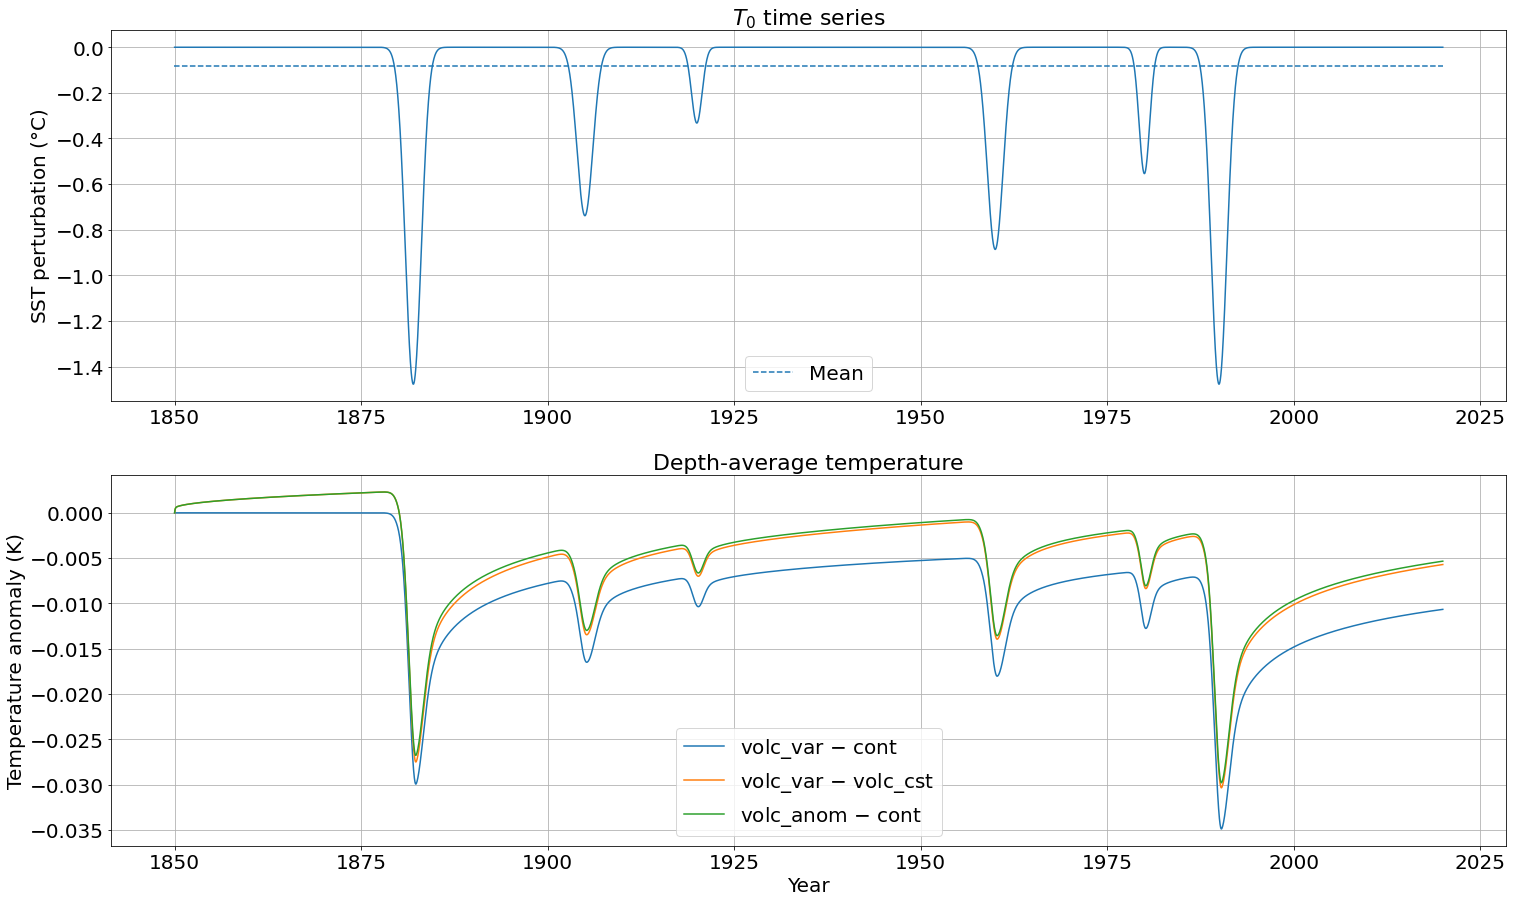

In [6]:
days = dt / 86400
timesteps = T_cont.shape[1]
length = (timesteps - 1) * days / 360 # 365? 
time_years = np.linspace(0, length, timesteps) + 1850

fig, axs = plt.subplots(ncols=1, nrows=2, figsize = (25, 15))

ax = axs[0]
ax.plot(time_years, T0_volc_var)
ax.axhline(y=np.mean(T0_volc_var), xmin=0.045, xmax=1-0.045, linestyle='--', label='Mean')
ax.set_title('$T_0$ time series', fontsize=22)
ax.set_xlabel('', fontsize=20)
ax.set_ylabel('SST perturbation ($\degree$C)', fontsize=20)
ax.tick_params(labelsize=20)
ax.grid()
ax.legend(fontsize=20, loc='lower center')

ax=axs[1]
ax.plot(time_years, OHC(T_volc_var - T_cont), label='volc_var $-$ cont')
ax.plot(time_years, OHC(T_volc_var - T_volc_cst), label='volc_var $-$ volc_cst')
# ax.plot(time_years, OHC(T_volc_cst - T_cont), label='volc_cst $-$ cont')
ax.plot(time_years, OHC(T_volc_anom - T_cont), label='volc_anom $-$ cont')
ax.set_title('Depth-average temperature', fontsize=22)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Temperature anomaly (K)', fontsize=20)
ax.tick_params(labelsize=20)
ax.grid()
ax.legend(fontsize=20, loc='lower center')
    
# plt.savefig('ch5_1D_fake_volcanoes_samediffusivity.jpg')

### Same as above, but now I change the diffusivity to see how the difference between the two anomaly methods (with or without background volcano) are sensitive to the background diffusivity

In [5]:
### Many kappas

kappas = np.array([1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5, 2.5e-5, 5e-5, 1e-4])
# for the largeer diffusivities to remain numerically stable, need to decrease dt to ensure the Von Neumann stability criterion

spin_up = 500
years = 170

OHC_volc_var_cont_kappas = []
OHC_volc_var_cst_kappas = []
#OHC_volc_anom_cont_kappas = []

# Intermediate run model function to be used for each diffusivity/dt combo

def run_volcanos_kappa(dt, kappa):
    # Calculate deep restoring given kappa and no more than 0.5C drift
    mu_initial_guess = 1 / (5 * 365 * 86400) # 1 / 5 years^-1
    mu_numerical_soln = fsolve(eqn, mu_initial_guess, kappa)
    mu = mu_numerical_soln[0]
    
    # Steady state given diffusivity
    v_ss = np.vectorize(steady_state)
    steady = v_ss(z_t)
        
    # Set length of experiment
    days = dt / 86400
    t_spinup = np.linspace(0.0, spin_up * 360, int(spin_up * 360 / days) + 1) # Spin-up period for time-mean volcanic forcing
    t = np.linspace(0.0, years * 360, int(years * 360 / days) + 1) # Experiment period
        
    # Set forcing
    T0_cont = np.full_like(t, 0)
    Q_cont = np.full_like(t, 0) 
    
    T0_volc_var = (-2000*normal(t, 32, 1.5) \
                        - 1000*normal(t, 55, 1.5) \
                        - 300*normal(t, 70, 1.) \
                        - 1200*normal(t, 110, 1.5) \
                        - 500*normal(t, 130, 1.0) \
                        - 2000*normal(t, 140, 1.5))
    Q_volc_var = 8 * T0_volc_var
        
    T0_volc_cst_spinup = np.mean(T0_volc_var) * np.full_like(t_spinup, 1) 
    Q_volc_cst_spinup = np.mean(Q_volc_var) * np.full_like(t_spinup, 1) 
        
    T0_volc_cst_cont = np.mean(T0_volc_var) * np.full_like(t, 1)
    Q_volc_cst_cont = np.mean(Q_volc_var) * np.full_like(t, 1) 
        
    # Run experiments
    T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years) # control (no forcing)

    T_volc_var = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_var, T0_volc_var, years) # volc_var (variable volcanic forcing)
    
    T_volc_cst_spinup = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_cst_spinup, T0_volc_cst_spinup, spin_up) # volc_cst (constant volcanic forcing equal to time-mean of variable volcanic forcing), 500 year spin-up

    T_volc_cst_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_volc_cst_spinup[:, - 1], Q_volc_cst_cont, T0_volc_cst_cont, years) # as above but using the spun-up period as the initial state to then use like a piControl
    
    T_volc_var_cst_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_volc_cst_spinup[:, - 1], Q_volc_var, T0_volc_var, years) # initial condition is the state spun-up to the time-mean of the variable forcing which will then be presvribed
    
    #T_volc_anom = model(dt, dz, z_m, z_d, z_b, kappas[k], gamma, steady, Q_volc_var - T0_volc_cst_cont, T0_volc_var - T0_volc_cst_cont, years) # volc_anom (variable volcanic forcing anomaly, zero time-mean forcing by construction)
        
    # Make into xarray dataarrays
    OHC_volc_var_cont = xr.DataArray(data=OHC(T_volc_var - T_cont), coords=dict(time = t / 360 + 1850))
    OHC_volc_var_cst = xr.DataArray(data=OHC(T_volc_var_cst_cont - T_volc_cst_cont), coords=dict(time = t / 360 + 1850))
    #OHC_volc_anom_cont = xr.DataArray(data=OHC(T_volc_anom - T_cont), coords=dict(time = t / 360 + 1850))
    
    return OHC_volc_var_cont, OHC_volc_var_cst#, OHC_volc_anom_cont
    

# Do the loop:

for k in range(len(kappas)):
    kappa = kappas[k]
    if kappa <= 1e-5:
        dt = 10.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa) # , OHC_volc_anom_cont
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)
        #OHC_volc_anom_cont_kappas.append(OHC_volc_anom_cont)

    elif kappa <= 2e-5:
        dt = 5.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa)
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)
        #OHC_volc_anom_cont_kappas.append(OHC_volc_anom_cont)
        
    elif kappa <= 5e-5:
        dt = 2.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa)
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)
        #OHC_volc_anom_cont_kappas.append(OHC_volc_anom_cont)
    
    else:
        dt = 1.0 * 86400
        OHC_volc_var_cont, OHC_volc_var_cst = run_volcanos_kappa(dt, kappa)
        
        OHC_volc_var_cont_kappas.append(OHC_volc_var_cont)
        OHC_volc_var_cst_kappas.append(OHC_volc_var_cst)
        #OHC_volc_anom_cont_kappas.append(OHC_volc_anom_cont)

/jobfs/30952212.gadi-pbs/ipykernel_860861/2009617058.py:181: RuntimeWarning: invalid value encountered in sqrt
  A = (1 + np.exp(2 * np.sqrt(mu / kappa) * (z_b - z_d))) * np.exp(np.sqrt(mu / kappa) * z_d)
/jobfs/30952212.gadi-pbs/ipykernel_860861/2009617058.py:183: RuntimeWarning: invalid value encountered in sqrt
  B = (T_0 - T_b) / (z_m - z_b) * (z_m - z_d - np.sqrt(kappa / mu) * np.exp(np.sqrt(mu / kappa) * (z_b - z_d)))
/jobfs/30952212.gadi-pbs/ipykernel_860861/2009617058.py:190: RuntimeWarning: invalid value encountered in sqrt
  E = (T_0 - T_b) / (z_m - z_b) * (1 - np.exp((z_b - z_d) * np.sqrt(mu / kappa)))
/jobfs/30952212.gadi-pbs/ipykernel_860861/2009617058.py:192: RuntimeWarning: invalid value encountered in sqrt
  F = np.sqrt(mu / kappa) * (1 - np.exp(2 * (z_b - z_d) * np.sqrt(mu / kappa))) * np.exp(z_d * np.sqrt(mu / kappa))
/jobfs/30952212.gadi-pbs/ipykernel_860861/2009617058.py:200: RuntimeWarning: invalid value encountered in sqrt
  equation = T_b_final - T_b - 2 * np.exp

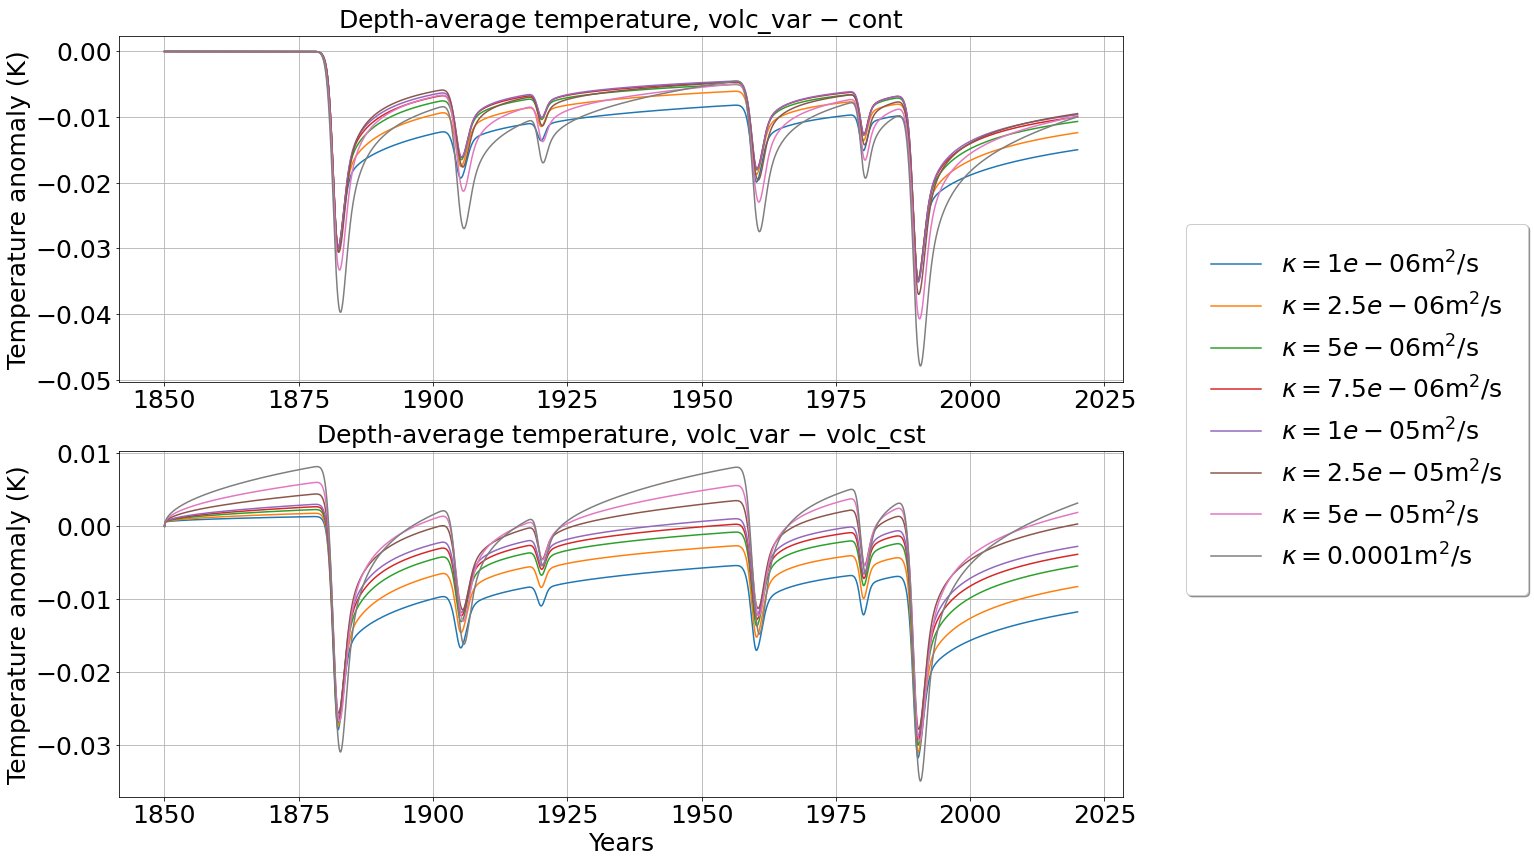

In [6]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize = (18, 14))

colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

ax = axs[0]
for i in range(len(OHC_volc_var_cont_kappas)):
    OHC_volc_var_cont_kappas[i].plot(ax=ax, label=f'$\kappa = {kappas[i]}$m$^2$/s')
    ax.set_title('Depth-average temperature, volc_var $-$ cont', fontsize=25)
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('Temperature anomaly (K)', fontsize=25)
    ax.tick_params(labelsize=25)
    ax.grid(b=True)
    #ax.legend(fontsize=20, loc='lower center')
    #ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1.05, 0.5),loc = 'center left', fontsize=18)


ax = axs[1]
for i in range(len(OHC_volc_var_cst_kappas)):
    OHC_volc_var_cst_kappas[i].plot(ax=ax, label=f'$\kappa = {kappas[i]}$m$^2$/s', color=colors[i])
    ax.set_title('Depth-average temperature, volc_var $-$ volc_cst', fontsize=25)
    ax.set_xlabel('Years', fontsize=25)
    ax.set_ylabel('Temperature anomaly (K)', fontsize=25)
    ax.tick_params(labelsize=25)
    ax.grid(b=True)
    ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,bbox_to_anchor=(1.05, 1.12),loc = 'center left', fontsize=25)

plt.savefig('ch5_1D_fake_volcanoes_diffdiffusivity.jpg',  bbox_inches='tight')

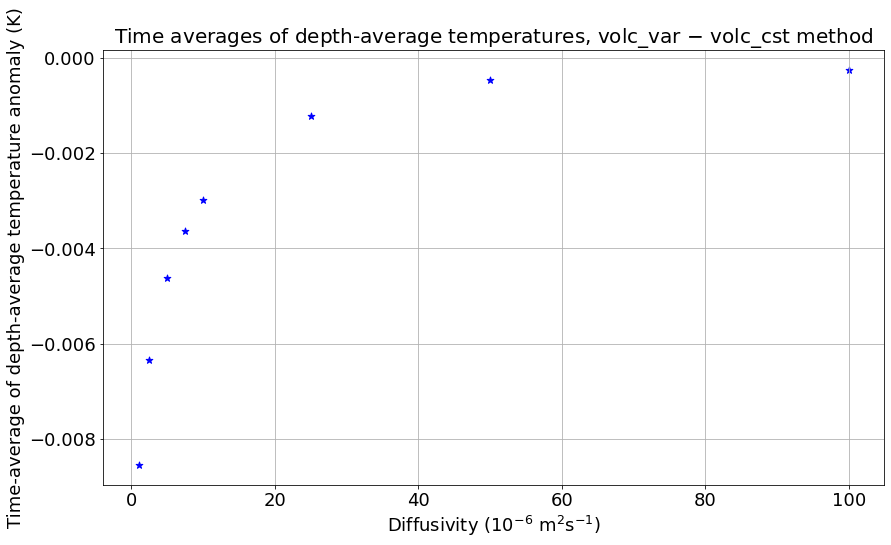

In [18]:
OHC_volc_var_cst_kappas[-1].mean(dim='time')

plt.figure(figsize=(14,8))
OHC_volc_var_averages = np.array([OHC_volc_var_cst_kappas[i].mean(dim='time') for i in range(len(OHC_volc_var_cst_kappas))])
plt.scatter(kappas/1e-6, OHC_volc_var_averages, s=50, marker='*', color='b')
plt.grid()
plt.ylabel('Time-average of depth-average temperature anomaly (K)', fontsize=18)
plt.xlabel(r'Diffusivity ($10^{-6}$ m$^2$s$^{-1}$)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Time averages of depth-average temperatures, volc_var $-$ volc_cst method', fontsize=20)
plt.savefig('ch5_1D_fake_volcanoes_diffdiffusivity_time_average.jpg',  bbox_inches='tight')

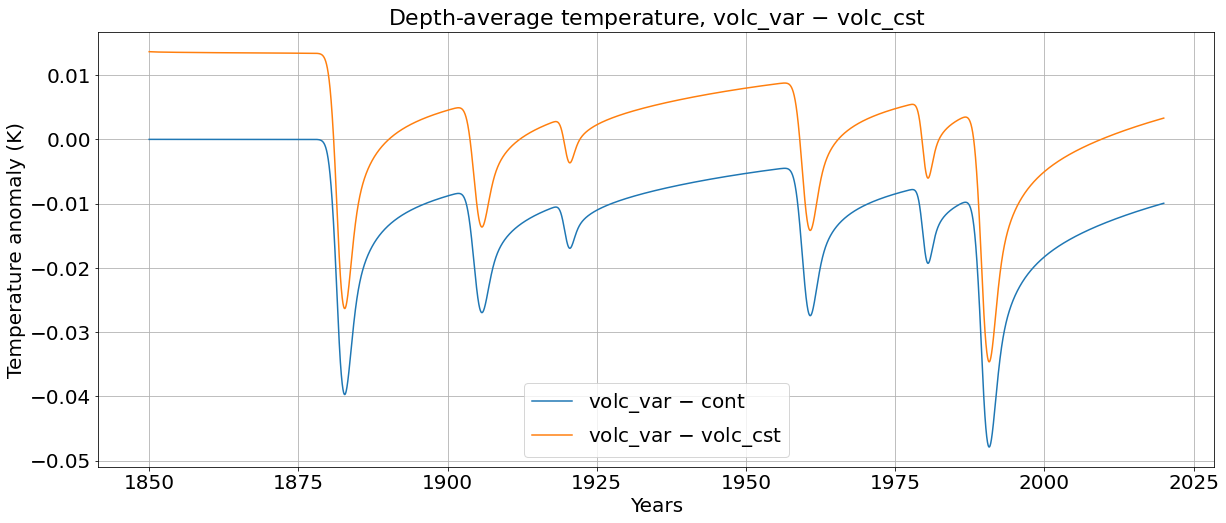

In [145]:
plt.figure(figsize=(20,8))

OHC_volc_var_cont.plot(label='volc_var $-$ cont')
OHC_volc_var_cst.plot(label='volc_var $-$ volc_cst')

plt.title('Depth-average temperature, volc_var $-$ volc_cst', fontsize=22)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Temperature anomaly (K)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(b=True)
plt.legend(fontsize=20, loc='lower center')

In [ ]:
### Examining the large diffusivity kappa = 1e-4

In [6]:
kappa = 1e-04
dt = 1.0 * 86400

# Calculate deep restoring given kappa and no more than 0.5C drift
mu_initial_guess = 1 / (5 * 365 * 86400) # 1 / 5 years^-1
mu_numerical_soln = fsolve(eqn, mu_initial_guess, kappa)
# mu_numerical_soln = 1 / (mu_numerical_soln * 360 * 86400)
mu = mu_numerical_soln[0]

v_ss = np.vectorize(steady_state)
steady = v_ss(z_t)
        
# Set length of experiment
spin_up = 500
years = 170
days = dt / 86400
t_spinup = np.linspace(0.0, years * 360, int(spin_up * 360 / days) + 1)
t_cont = np.linspace(0.0, years * 360, int(years * 360 / days) + 1)

# Set forcing
T0_cont = np.full_like(t_cont, 0)
Q_cont = np.full_like(t_cont, 0) 
        
T0_volc_var = (-2000*normal(t_cont, 32, 1.5) \
                        - 1000*normal(t_cont, 55, 1.5) \
                        - 300*normal(t_cont, 70, 1.) \
                        - 1200*normal(t_cont, 110, 1.5) \
                        - 500*normal(t_cont, 130, 1.0) \
                        - 2000*normal(t_cont, 140, 1.5))
Q_volc_var = 8 * T0_volc_var
      
T0_volc_cst_spinup = np.mean(T0_volc_var) * np.full_like(t_spinup, 1)
Q_volc_cst_spinup = np.mean(Q_volc_var) * np.full_like(t_spinup, 1)     
    
T0_volc_cst_cont = np.mean(T0_volc_var) * np.full_like(t_cont, 1)
Q_volc_cst_cont = np.mean(Q_volc_var) * np.full_like(t_cont, 1) 
        
### Run experiments


T_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_cont, T0_cont, years) # cont (no forcing)

T_volc_var = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_var, T0_volc_var, years) # volc_var (variable volcanic forcing)

T_volc_cst_spinup = model(dt, dz, z_m, z_d, z_b, kappa, gamma, steady, Q_volc_cst_spinup, T0_volc_cst_spinup, spin_up) # volc_cst (constant volcanic forcing equal to time-mean of variable volcanic forcing), 500 year spin-up

T_volc_cst_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_volc_cst_spinup[:, - 1], Q_volc_cst_cont, T0_volc_cst_cont, years) # as above but using the spun-up period as the initial state to then use like a piControl

T_volc_var_cst_cont = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_volc_cst_spinup[:, - 1], Q_volc_var, T0_volc_var, years) # volc_var forcing but with volc_cst spin-up


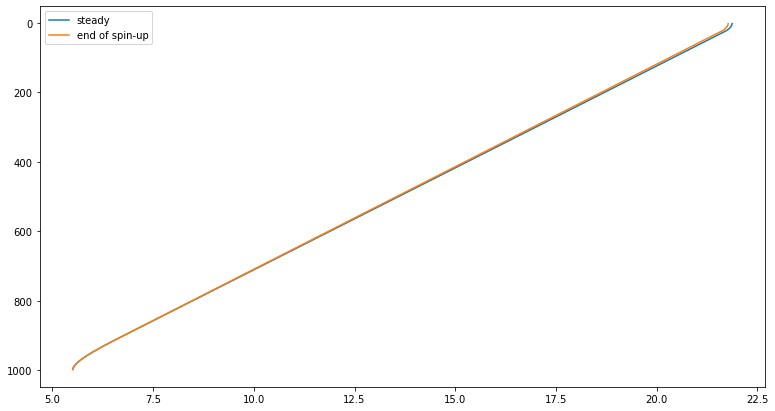

In [7]:
plt.figure(figsize=(13,7))
plt.plot(T_volc_cst_spinup[:,0], z_t, label='steady')
plt.plot(T_volc_cst_cont[:,-1], z_t, label='end of spin-up')
plt.gca().invert_yaxis()
plt.legend()

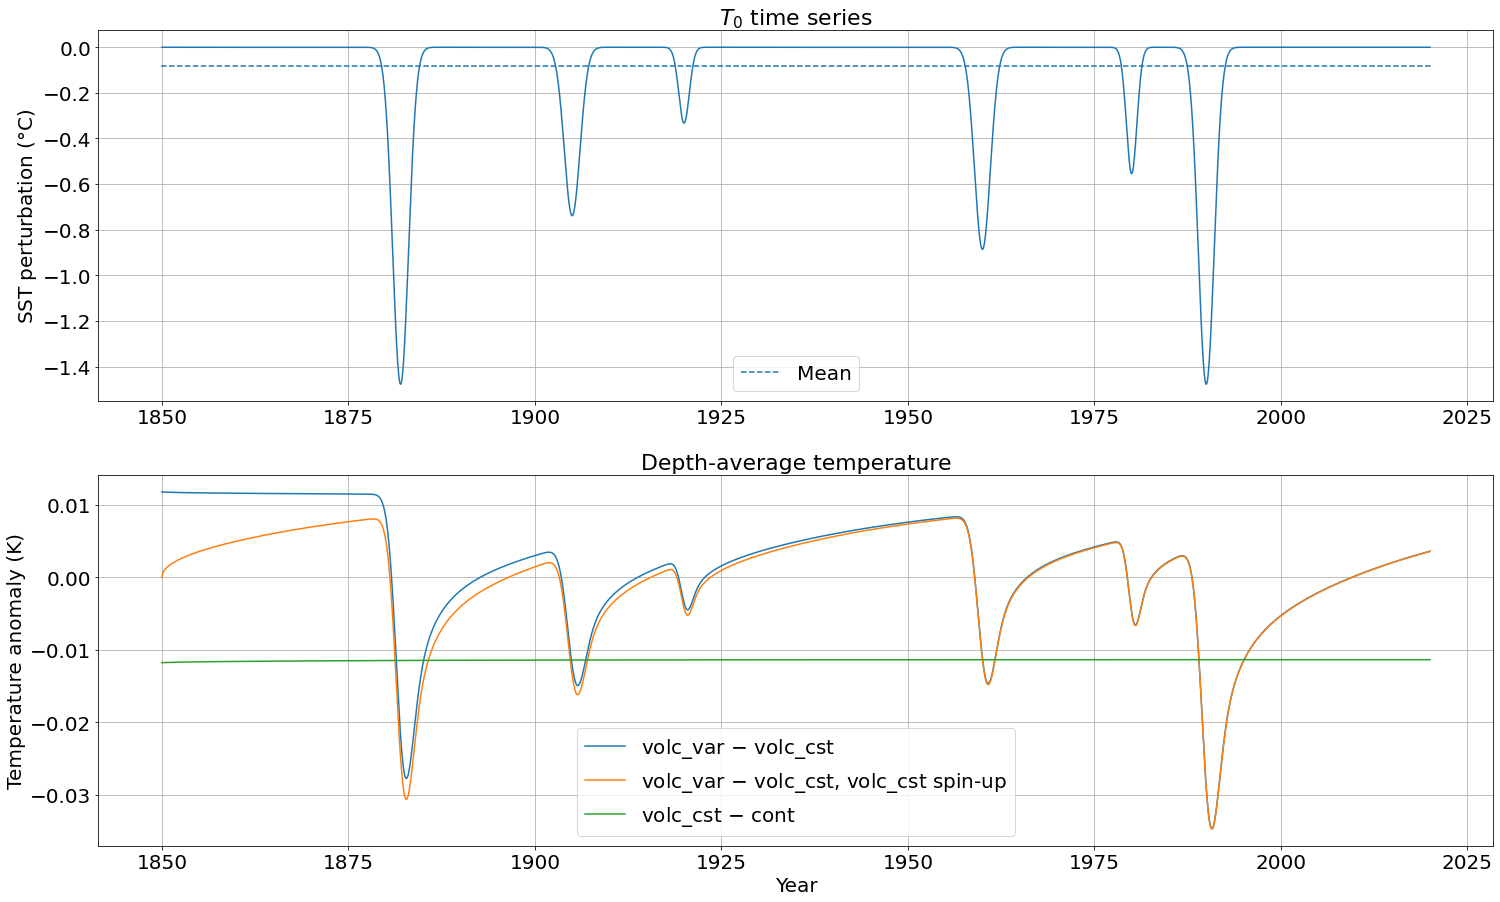

In [9]:
days = dt / 86400
timesteps = T_cont.shape[1]
length = (timesteps - 1) * days / 360 # 365? 
time_years = np.linspace(0, length, timesteps) + 1850

fig, axs = plt.subplots(ncols=1, nrows=2, figsize = (25, 15))

ax = axs[0]
ax.plot(time_years, T0_volc_var)
ax.axhline(y=np.mean(T0_volc_var), xmin=0.045, xmax=1-0.045, linestyle='--', label='Mean')
ax.set_title('$T_0$ time series', fontsize=22)
ax.set_xlabel('', fontsize=20)
ax.set_ylabel('SST perturbation ($\degree$C)', fontsize=20)
ax.tick_params(labelsize=20)
ax.grid()
ax.legend(fontsize=20, loc='lower center')

ax=axs[1]
ax.plot(time_years, OHC(T_volc_var - T_volc_cst_cont), label='volc_var $-$ volc_cst')
#ax.plot(time_years, OHC(T_volc_var - T_cont), label='volc_var $-$ cont')
ax.plot(time_years, OHC(T_volc_var_cst_cont - T_volc_cst_cont), label='volc_var $-$ volc_cst, volc_cst spin-up')
ax.plot(time_years, OHC(T_volc_cst_cont - T_cont), label='volc_cst $-$ cont')
ax.set_title('Depth-average temperature', fontsize=22)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Temperature anomaly (K)', fontsize=20)
ax.tick_params(labelsize=20)
ax.grid()
ax.legend(fontsize=20, loc='lower center')